In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
from scipy.stats import chi2

In [3]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
transactions = pd.read_csv("transactions.csv")

# Nettoyage

## Customers 

In [4]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [5]:
#vérification unicité clé primaire
print("Doublon client_id:",customers.duplicated(subset='client_id').sum())
print("Na :",customers.isnull().sum())

Doublon client_id: 0
Na : client_id    0
sex          0
birth        0
dtype: int64


In [6]:
#vérification de valeurs abérantes pour le sexe
customers['sex'].unique()

array(['f', 'm'], dtype=object)

In [7]:
#Vérification de outliers pour l'âge
print("Année max :",customers['birth'].max()," ","Année min :",customers['birth'].min())

Année max : 2004   Année min : 1929


## Products 

In [8]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [9]:
#Vérification de l'unicité de la clé primaire
print("Doublon id_prod:",products.duplicated(subset='id_prod').sum())
print("Na :",products.isnull().sum())

Doublon id_prod: 0
Na : id_prod    0
price      0
categ      0
dtype: int64


In [10]:
#Vérification outliers pour l'âge
products['price'].describe()

count    3287.000000
mean       21.856641
std        29.847908
min        -1.000000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: price, dtype: float64

In [11]:
#Vérification des valeurs aberrantes pour les catégories
products['categ'].unique()

array([0, 1, 2], dtype=int64)

In [12]:
products.loc[(products['price'] == 300) | (products['price'] == -1)]

,id_prod,price,categ
731,T_0,-1.0,0
947,2_2,300.0,2


In [13]:
products.loc[(products['categ'] == 2)]

,id_prod,price,categ
10,2_228,225.17,2
38,2_100,72.11,2
64,2_89,107.99,2
73,2_225,157.99,2
79,2_187,157.99,2
...,...,...,...
3188,2_99,84.99,2
3196,2_238,93.92,2
3267,2_101,63.99,2
3271,2_123,147.99,2


## Transactions 

### Doublon 

In [14]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [15]:
#Vérification de l'unicité de la clé primaire
print("Doublon:",transactions.duplicated().sum())
print("Na :",transactions.isnull().sum())

Doublon: 126
Na : id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


In [16]:
#Analyse des doublons
doublon_tr = transactions.loc[transactions.duplicated(subset = ['id_prod','date','session_id','client_id'],keep=False),:]

In [17]:
doublon_tr.head()

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
19312,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0


In [18]:
doublon_tr.describe()

,id_prod,date,session_id,client_id
count,183,183,183,183
unique,1,36,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,183,13,183,96


In [19]:
transactions.loc[transactions['date'].str.contains("test", case=False)]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [20]:
doublon_tr.loc[doublon_tr['date'] == "test_2021-03-01 02:30:02.237419"]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
52424,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
130188,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
168341,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
185962,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_1
311604,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_1


# Merge

In [21]:
#Fusionner la table transactions et produits
liaison_table = transactions.merge(products, how='left', on='id_prod',indicator=True)

In [22]:
liaison_table.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0.0,both
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,both


In [23]:
#catg 0 + imput moyenne / Analyse des lefts only
left_only = liaison_table.loc[liaison_table['_merge'] == 'left_only']

In [24]:
liaison_table.loc[liaison_table['_merge'] == 'left_only'] #catg 0

,id_prod,date,session_id,client_id,price,categ,_merge
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only
...,...,...,...,...,...,...,...
669730,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,NaN,NaN,left_only
670682,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,NaN,NaN,left_only
671286,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,NaN,NaN,left_only
675679,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,NaN,NaN,left_only


In [25]:
left_only.head()

,id_prod,date,session_id,client_id,price,categ,_merge
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only


In [26]:
#Imputation par la moyenne des valeurs manquantes

moy_categ_0 = liaison_table.loc[liaison_table['categ'] == 0]

left_only['categ'] = 0
left_only['price'] = moy_categ_0['price'].mean()

left_only.head()

,id_prod,date,session_id,client_id,price,categ,_merge
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,10.632588,0,left_only
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,10.632588,0,left_only
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,10.632588,0,left_only
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,10.632588,0,left_only
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,10.632588,0,left_only


In [27]:
#Left only contient un seul produit avec aucun prix
left_only['id_prod'].unique()

array(['0_2245'], dtype=object)

In [28]:
liaison_table.loc[liaison_table['_merge'] == 'right_only']

,id_prod,date,session_id,client_id,price,categ,_merge


In [29]:
liaison_table = liaison_table.drop(liaison_table[liaison_table['id_prod'] == '0_2245'].index)

In [30]:
print("Doublon:",liaison_table.duplicated().sum())
print("NA:",liaison_table.isnull().sum())

Doublon: 126
NA: id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
_merge        0
dtype: int64


### Création d'une table test 

In [31]:
#Contient toutes les dates avec le terme "test"
table_test = liaison_table.loc[liaison_table['date'].str.contains("test", case=False)]

In [32]:
table_test.head()

,id_prod,date,session_id,client_id,price,categ,_merge
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0,-1.0,0.0,both
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,-1.0,0.0,both
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,-1.0,0.0,both
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0,-1.0,0.0,both
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0,-1.0,0.0,both


### Table sans les tests 

In [33]:
#Table sans les tests
data = liaison_table[liaison_table["date"].str.contains("test") == False]

In [34]:
data.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0.0,both
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,both


In [35]:
print("Doublon:",data.duplicated().sum())
print("NA:",data.isnull().sum())

Doublon: 0
NA: id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
_merge        0
dtype: int64


In [36]:
#Rajouter les lignes manquantes 

data = pd.concat([data, left_only])

data.reset_index(inplace=True)

data.drop('index', axis=1,inplace = True)

In [37]:
print("Doublon:",data.duplicated().sum())

Doublon: 0


In [38]:
data.loc[data['id_prod'] == '0_2245']

,id_prod,date,session_id,client_id,price,categ,_merge
679111,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,10.632588,0.0,left_only
679112,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,10.632588,0.0,left_only
679113,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,10.632588,0.0,left_only
679114,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,10.632588,0.0,left_only
679115,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,10.632588,0.0,left_only
...,...,...,...,...,...,...,...
679327,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,10.632588,0.0,left_only
679328,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,10.632588,0.0,left_only
679329,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,10.632588,0.0,left_only
679330,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,10.632588,0.0,left_only


### Format Datetime + format dd/mm/aaaa 

In [39]:
#format string -> format datetime
data['date'] = pd.to_datetime(data['date'])

In [40]:
data.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0.0,both
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,both


In [41]:
#Passe au format jour/mois/année
data['date'] = data['date'].dt.strftime('%d/%m/%Y')
#data['date'] = data['date'].dt.strftime('%Y')

In [42]:
data.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,20/05/2022,s_211425,c_103,4.18,0.0,both
1,1_251,02/02/2022,s_158752,c_8534,15.99,1.0,both
2,0_1277,18/06/2022,s_225667,c_6714,7.99,0.0,both
3,2_209,24/06/2021,s_52962,c_6941,69.99,2.0,both
4,0_1509,11/01/2023,s_325227,c_4232,4.99,0.0,both


In [43]:
data['date'] = pd.to_datetime(data['date'])

In [44]:
data_2021 = data.loc[data['date'].dt.year == 2021]
data_2022 = data.loc[data['date'].dt.year == 2022]
data_2023 = data.loc[data['date'].dt.year == 2023]


In [45]:
data_2021['price'].sum()

4771751.595171602

In [46]:
data_2022['price'].sum()

6109957.720581518

In [47]:
data_2021.head()

,id_prod,date,session_id,client_id,price,categ,_merge
3,2_209,2021-06-24,s_52962,c_6941,69.99,2.0,both
7,0_2110,2021-06-26,s_54122,c_7456,7.04,0.0,both
9,1_299,2021-11-29,s_126880,c_1847,13.99,1.0,both
11,1_281,2021-06-06,s_45036,c_1522,23.99,1.0,both
14,0_1083,2021-04-09,s_85002,c_7769,16.99,0.0,both


In [48]:
data_2021.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
price                float64
categ                float64
_merge              category
dtype: object

In [49]:
data_2021['date'] = data['date'].dt.strftime('%m-%Y')
data_2021_date = data_2021.groupby(['date']).sum('price')
data_2021_date.head()

,price,categ
date,,
01-2021,163056.382941,4083.0
02-2021,154965.917765,3790.0
03-2021,446855.765882,11002.0
04-2021,436707.208117,9976.0
05-2021,453943.702941,10835.0


In [50]:
data_2022['date'] = data['date'].dt.strftime('%m-%Y')
data_2022_date = data_2022.groupby(['date']).sum('price')
data_2022_date.head()

,price,categ
date,,
01-2022,521133.120705,14911.0
02-2022,512245.733294,13526.0
03-2022,510867.156235,12866.0
04-2022,498085.130705,13077.0
05-2022,523874.373294,13594.0


In [51]:
data_2023['date'] = data['date'].dt.strftime('%m-%Y')
data_2023_date = data_2023.groupby(['date']).sum('price')
data_2023_date.head()

,price,categ
date,,
01-2023,347863.895529,8911.0
02-2023,298680.610353,7754.0
03-2023,32967.012588,902.0
04-2023,31782.990000,792.0
05-2023,32584.270000,912.0


# Indicateur chiffre d'affaire (CA)

In [52]:
#Création du x et y pour le graphique
x = ["Janv", "Fev", "Mar","Avr","Mai","Jun","Jui","Aou","Sep","Oct","Nov","Dec"]

y_2021 = data_2021_date['price']
y_2022 = data_2022_date['price']
y_2023 = data_2023_date['price']

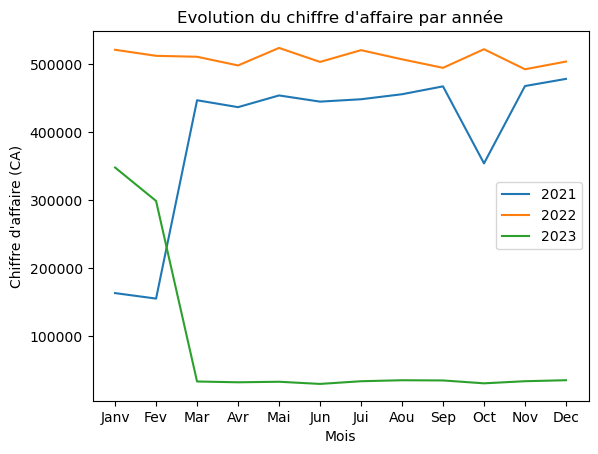

In [53]:
#Création du graphique

plt.plot(x, y_2021, label = "2021")
plt.plot(x, y_2022, label = "2022")
plt.plot(x, y_2023, label = "2023")

plt.xlabel('Mois')
plt.ylabel("Chiffre d'affaire (CA)")

plt.title("Evolution du chiffre d'affaire par année")

plt.legend()

plt.show()

# Moyenne mobile (3) 

## Moyenne mobile 2021-2023 

In [54]:
data.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20,s_211425,c_103,4.18,0.0,both
1,1_251,2022-02-02,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022-06-18,s_225667,c_6714,7.99,0.0,both
3,2_209,2021-06-24,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023-11-01,s_325227,c_4232,4.99,0.0,both


In [55]:
#data['date'] = pd.to_datetime(data['date'])

data_month = data

data_month['date'] = data_month['date'].dt.strftime('%Y/%m')


data_month = data_month.sort_values(by='date')

data_mm = data_month.groupby(['date']).sum()

data_mm.reset_index(inplace=True)


data_mm.head()

,date,price,categ
0,2021/01,163056.382941,4083.0
1,2021/02,154965.917765,3790.0
2,2021/03,446855.765882,11002.0
3,2021/04,436707.208117,9976.0
4,2021/05,453943.702941,10835.0


In [56]:
#Calcul de la moyenne mobile / Prendre 7 jours, afficher par mois
moyenne_mobile_data = data_mm['price'].rolling(window=3).mean()

# Ajouter la colonne de la moyenne mobile à la dataframe
data_mm['moyenne_mobile'] = moyenne_mobile_data

In [57]:
data_mm.head()

,date,price,categ,moyenne_mobile
0,2021/01,163056.382941,4083.0,NaN
1,2021/02,154965.917765,3790.0,NaN
2,2021/03,446855.765882,11002.0,254959.355529
3,2021/04,436707.208117,9976.0,346176.297255
4,2021/05,453943.702941,10835.0,445835.558980


In [58]:
x = data_mm['date']
y_data_mm = data_mm['moyenne_mobile']
y_data_2 = data_mm['price']

In [59]:
import matplotlib.ticker as ticker

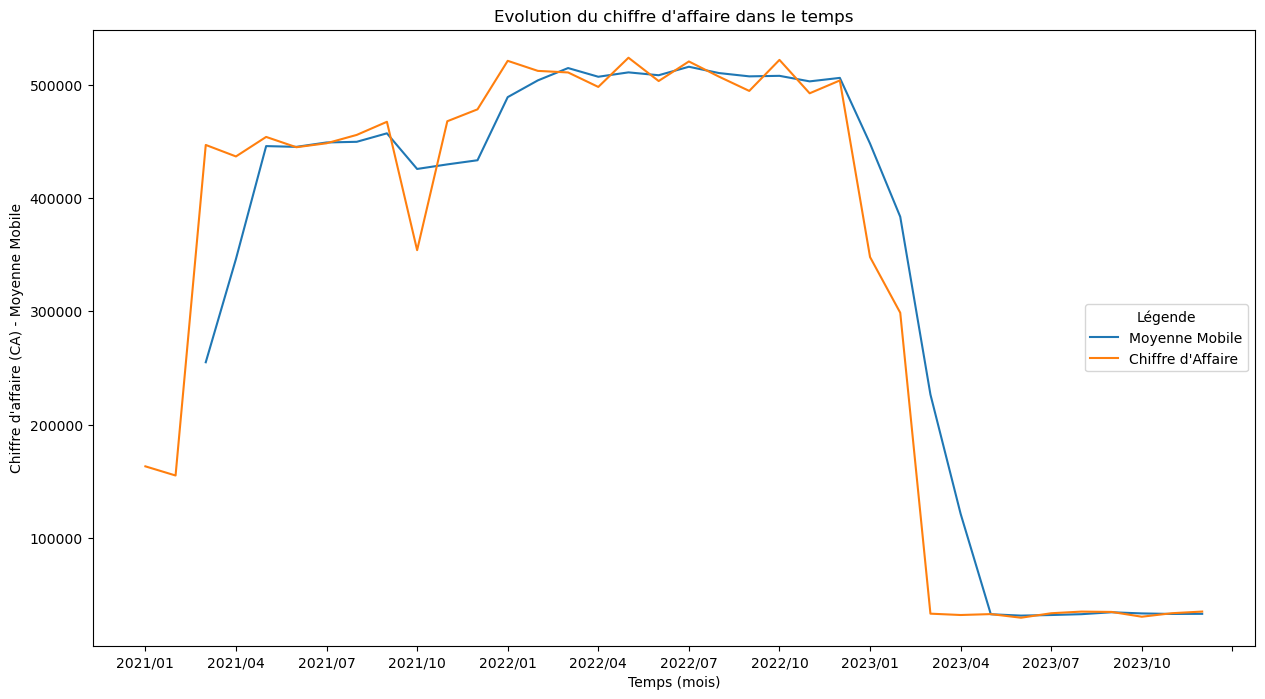

In [60]:
#Création du graphique

#Fenêtre plus grande
fig = plt.figure(figsize=(15, 8))

plt.plot(x, y_data_mm,label='Moyenne Mobile')
plt.plot(x, y_data_2,label="Chiffre d'Affaire")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.xlabel('Temps (mois)')
plt.ylabel("Chiffre d'affaire (CA) - Moyenne Mobile")

plt.title("Evolution du chiffre d'affaire dans le temps")

plt.legend(title='Légende', loc='right')

plt.show()


In [61]:
#Courbe de lorenz
data_client = data.groupby(['client_id']).sum().reset_index()
data_client.head()

,client_id,price,categ
0,c_1,558.18,10.0
1,c_10,1353.60,42.0
2,c_100,254.85,7.0
3,c_1000,2261.89,82.0
4,c_1001,1812.86,33.0


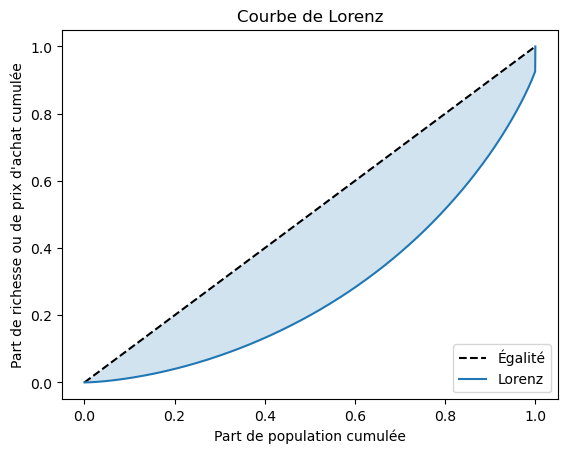

In [62]:


# Tri des données
data_client = data_client.sort_values(by='price').reset_index(drop=True)

# Calcul de la courbe de Lorenz
cumulative_perc = np.cumsum(data_client['price']) / np.sum(data_client['price'])
Lorenz_curve = np.concatenate([[0], cumulative_perc])

# Tracé de la courbe de Lorenz
plt.plot(np.linspace(0,1,len(data_client)+1), np.linspace(0,1,len(data_client)+1), 'k--', label='Égalité')
plt.plot(np.linspace(0,1,len(data_client)+1), Lorenz_curve, label='Lorenz')
plt.fill_between(np.linspace(0,1,len(data_client)+1), np.linspace(0,1,len(data_client)+1), Lorenz_curve, alpha=0.2)
plt.legend(loc='lower right')
plt.xlabel('Part de population cumulée')
plt.ylabel("Part de richesse ou de prix d'achat cumulée")
plt.title('Courbe de Lorenz')
plt.show()

# Cas Oct 2021

In [63]:
data_v2 = liaison_table[liaison_table["date"].str.contains("test") == False]

In [64]:
data_v2.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0.0,both
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,both


In [65]:
data_v2['date'] = pd.to_datetime(data_v2['date'])

data_v2['date'] = data_v2['date'].dt.strftime('%Y/%m/%d')

data_v2.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022/05/20,s_211425,c_103,4.18,0.0,both
1,1_251,2022/02/02,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022/06/18,s_225667,c_6714,7.99,0.0,both
3,2_209,2021/06/24,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023/01/11,s_325227,c_4232,4.99,0.0,both


In [66]:
data_v2['date'] = pd.to_datetime(data_v2['date'])

oct_2021 = data_v2.loc[(data_v2['date'].dt.month == 10) & (data_v2['date'].dt.year == 2021)]

In [67]:
oct_2021.head()

,id_prod,date,session_id,client_id,price,categ,_merge
68,0_1409,2021-10-02,s_99013,c_5725,4.99,0.0,both
71,0_1247,2021-10-03,s_99443,c_3394,15.99,0.0,both
80,0_1272,2021-10-13,s_104207,c_8534,17.01,0.0,both
86,0_1102,2021-10-24,s_109442,c_1609,4.63,0.0,both
93,0_1079,2021-10-05,s_100557,c_7918,5.99,0.0,both


In [68]:
oct_2021.describe()

,price,categ
count,21599.000000,21599.000000
mean,14.852481,0.185564
std,17.780353,0.509483
min,0.620000,0.000000
25%,6.990000,0.000000
50%,11.030000,0.000000
75%,15.990000,0.000000
max,247.220000,2.000000


In [69]:
oct_2021_ct_1 = oct_2021.loc[(oct_2021['categ'] == 1)]

In [70]:
#Analyse d'octobre 2021 / Valeurs manquantes / Décision finale -> archivage du mois en question
oct_2021_ct_1['date'].unique()

array(['2021-10-30T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
       '2021-10-29T00:00:00.000000000', '2021-10-01T00:00:00.000000000',
       '2021-10-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [71]:
oct_2021_ct_2 = oct_2021.loc[(oct_2021['categ'] == 2)]

In [72]:
oct_2021_ct_2['date'].unique()

array(['2021-10-20T00:00:00.000000000', '2021-10-23T00:00:00.000000000',
       '2021-10-02T00:00:00.000000000', '2021-10-29T00:00:00.000000000',
       '2021-10-06T00:00:00.000000000', '2021-10-13T00:00:00.000000000',
       '2021-10-26T00:00:00.000000000', '2021-10-01T00:00:00.000000000',
       '2021-10-27T00:00:00.000000000', '2021-10-08T00:00:00.000000000',
       '2021-10-15T00:00:00.000000000', '2021-10-17T00:00:00.000000000',
       '2021-10-14T00:00:00.000000000', '2021-10-04T00:00:00.000000000',
       '2021-10-09T00:00:00.000000000', '2021-10-07T00:00:00.000000000',
       '2021-10-19T00:00:00.000000000', '2021-10-28T00:00:00.000000000',
       '2021-10-31T00:00:00.000000000', '2021-10-18T00:00:00.000000000',
       '2021-10-05T00:00:00.000000000', '2021-10-10T00:00:00.000000000',
       '2021-10-30T00:00:00.000000000', '2021-10-11T00:00:00.000000000',
       '2021-10-12T00:00:00.000000000', '2021-10-03T00:00:00.000000000',
       '2021-10-25T00:00:00.000000000', '2021-10-16

In [73]:
#Archivage du mois d'octobre 2021

data['date'] = pd.to_datetime(data['date'])

data.loc[(data['date'].dt.month != 10) & (data['date'].dt.year != 2021)]



,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-01,s_211425,c_103,4.180000,0.0,both
1,1_251,2022-02-01,s_158752,c_8534,15.990000,1.0,both
2,0_1277,2022-06-01,s_225667,c_6714,7.990000,0.0,both
4,0_1509,2023-11-01,s_325227,c_4232,4.990000,0.0,both
6,0_1475,2022-03-01,s_218033,c_7782,11.990000,0.0,both
...,...,...,...,...,...,...,...
679322,0_2245,2022-03-01,s_202874,c_5056,10.632588,0.0,left_only
679324,0_2245,2022-08-01,s_257900,c_5120,10.632588,0.0,left_only
679328,0_2245,2022-06-01,s_175311,c_4167,10.632588,0.0,left_only
679329,0_2245,2022-05-01,s_209381,c_4453,10.632588,0.0,left_only


In [74]:
data_clear = data.loc[data["date"].dt.strftime("%Y-%m-%d") != "2021-10-01"]

data_clear.loc[(data_clear['date'].dt.month == 10) & (data_clear['date'].dt.year == 2021)]

,id_prod,date,session_id,client_id,price,categ,_merge


## CA / CATEG 

In [75]:
data_test = data_clear.groupby(['date','categ']).sum()

In [76]:
data_test.reset_index(inplace=True)

In [77]:
data_test.head()

,date,categ,price
0,2021-01-01,0.0,61072.442941
1,2021-01-01,1.0,63822.550000
2,2021-01-01,2.0,38161.390000
3,2021-02-01,0.0,59812.807765
4,2021-02-01,1.0,57565.480000


In [78]:
aaa = data_test.groupby('categ').sum()

aaa.reset_index(inplace=True)

aaa.head()

,categ,price
0,0.0,4.243861e+06
1,1.0,4.570528e+06
2,2.0,2.687743e+06


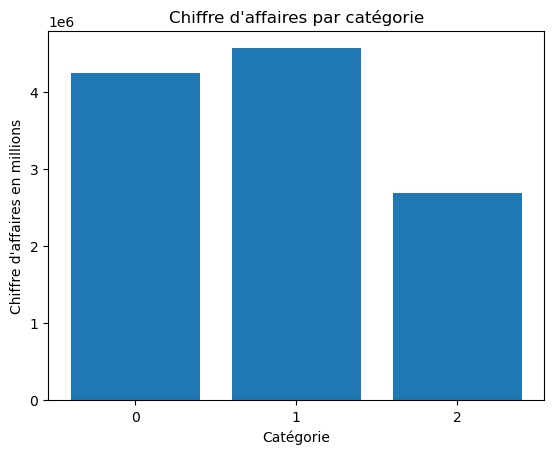

In [79]:
x = ["0","1","2"]
y = aaa['price']

# Créer le graphique
graphique = plt.bar(x, y)

# Configurer les axes et le titre
plt.title("Chiffre d'affaires par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires en millions")

plt.show()

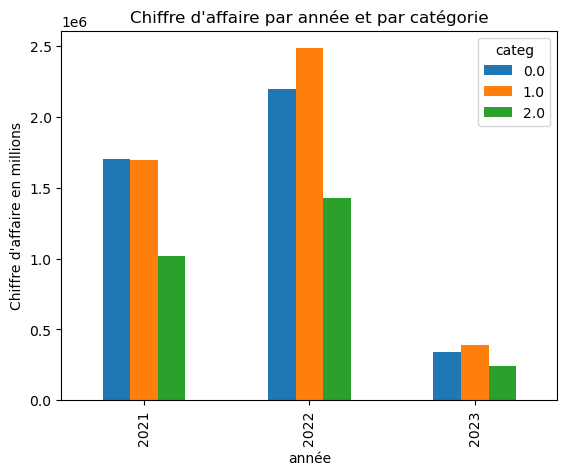

In [80]:
data_test['date'] = pd.to_datetime(data_test['date'])

data_test['date'] = pd.to_datetime(data_test['date'], format='%m/%Y')

data_test['année'] = data_test['date'].dt.year

df_grouped = data_test.groupby(['année', 'categ'])['price'].sum().reset_index()

# Pivoter le dataframe pour avoir une colonne par catégorie
df_pivot = df_grouped.pivot(index='année', columns='categ', values='price')

# Créer le graphique
df_pivot.plot(kind='bar')

# Configurer les axes et le titre
plt.ylabel('Chiffre d\'affaire en millions')
plt.title('Chiffre d\'affaire par année et par catégorie')

# Afficher le graphique
plt.show()

In [81]:
#Group by par client pour voir l'impact des clients / Effet pareto et courbe de Lorenz

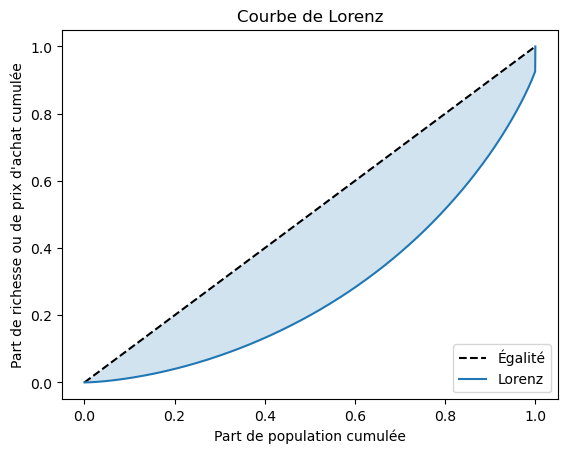

In [82]:

# Tri des données
data_client = data_client.sort_values(by='price').reset_index(drop=True)

# Calcul de la courbe de Lorenz
cumulative_perc = np.cumsum(data_client['price']) / np.sum(data_client['price'])
Lorenz_curve = np.concatenate([[0], cumulative_perc])

# Tracé de la courbe de Lorenz
plt.plot(np.linspace(0,1,len(data_client)+1), np.linspace(0,1,len(data_client)+1), 'k--', label='Égalité')
plt.plot(np.linspace(0,1,len(data_client)+1), Lorenz_curve, label='Lorenz')
plt.fill_between(np.linspace(0,1,len(data_client)+1), np.linspace(0,1,len(data_client)+1), Lorenz_curve, alpha=0.2)
plt.legend(loc='lower right')
plt.xlabel('Part de population cumulée')
plt.ylabel("Part de richesse ou de prix d'achat cumulée")
plt.title('Courbe de Lorenz')
plt.show()

In [83]:
data_test.head()

,date,categ,price,année
0,2021-01-01,0.0,61072.442941,2021
1,2021-01-01,1.0,63822.550000,2021
2,2021-01-01,2.0,38161.390000,2021
3,2021-02-01,0.0,59812.807765,2021
4,2021-02-01,1.0,57565.480000,2021


# Requête Julie

In [84]:
#le lien entre le genre d’un client et les catégories des livres achetés
#"" l’âge des clients et le montant total, la fréquence d’achat,la taille du panier moyen et les catégories des livres 

In [85]:
#Faire tableau de contingence

In [86]:
data.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0,both
1,1_251,2022-02-01,s_158752,c_8534,15.99,1.0,both
2,0_1277,2022-06-01,s_225667,c_6714,7.99,0.0,both
3,2_209,2021-06-01,s_52962,c_6941,69.99,2.0,both
4,0_1509,2023-11-01,s_325227,c_4232,4.99,0.0,both


In [87]:
#suppression de la colonne merge
data.drop('_merge', axis=1,inplace = True)

In [88]:
data.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0
1,1_251,2022-02-01,s_158752,c_8534,15.99,1.0
2,0_1277,2022-06-01,s_225667,c_6714,7.99,0.0
3,2_209,2021-06-01,s_52962,c_6941,69.99,2.0
4,0_1509,2023-11-01,s_325227,c_4232,4.99,0.0


In [89]:
data_f = data.merge(customers, how='outer', on='client_id',indicator=True)


In [90]:
data_f.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,_merge
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0,f,1986,both
1,0_1627,2022-06-01,s_225494,c_103,3.99,0.0,f,1986,both
2,0_1104,2023-08-01,s_338755,c_103,13.21,0.0,f,1986,both
3,0_1390,2021-04-01,s_23078,c_103,19.37,0.0,f,1986,both
4,0_1547,2022-03-01,s_179629,c_103,8.99,0.0,f,1986,both


In [91]:
right_only = data_f.loc[data_f['_merge'] == 'right_only']

In [92]:
data_f = data_f.drop(data_f[data_f['_merge'] == 'right_only'].index)

data_f 

,id_prod,date,session_id,client_id,price,categ,sex,birth,_merge
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0,f,1986,both
1,0_1627,2022-06-01,s_225494,c_103,3.99,0.0,f,1986,both
2,0_1104,2023-08-01,s_338755,c_103,13.21,0.0,f,1986,both
3,0_1390,2021-04-01,s_23078,c_103,19.37,0.0,f,1986,both
4,0_1547,2022-03-01,s_179629,c_103,8.99,0.0,f,1986,both
...,...,...,...,...,...,...,...,...,...
679327,0_1509,2021-05-01,s_34762,c_8114,4.99,0.0,m,1962,both
679328,1_152,2021-08-01,s_116675,c_240,11.06,1.0,m,1998,both
679329,2_207,2021-01-01,s_42418,c_305,50.99,2.0,f,1996,both
679330,1_521,2022-10-01,s_284060,c_305,22.99,1.0,f,1996,both


In [93]:
df_grouped = data_f.groupby(['sex', 'categ'])['id_prod'].count().reset_index()
df_grouped.head()

,sex,categ,id_prod
0,f,0.0,206220
1,f,1.0,114899
2,f,2.0,17283
3,m,0.0,209460
4,m,1.0,112270


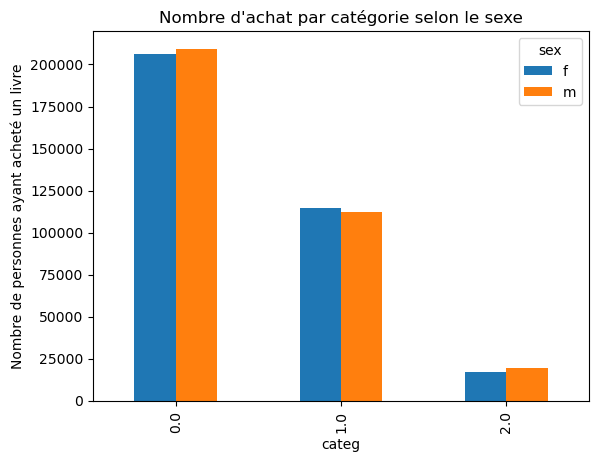

In [94]:
# Pivoter le dataframe pour avoir une colonne par catégorie
df_pivot = df_grouped.pivot(index='categ', columns='sex', values='id_prod')

# Créer le graphique
df_pivot.plot(kind='bar')

# Configurer les axes et le titre
plt.ylabel('Nombre de personnes ayant acheté un livre')
plt.title("Nombre d'achat par catégorie selon le sexe")

# Afficher le graphique
plt.show()

In [95]:
#Théorie : Pas de corélation entre le sexe et les catégories

#Regarder variable : test différent pour type de variable spécifique

#Sexe : qualitative / Catégorie : Qualitative / Comprendre à quoi correspondent les formules de tests

#Essayer de faire graphiques de tests si possible

df_pivot.head()

sex,f,m
categ,,
0.0,206220,209460
1.0,114899,112270
2.0,17283,19200


# Fonction tests statistiques

In [96]:
#Test de normalité - Test gaussiens

def test_normal(data_quantitative,alpha):
    from scipy.stats import kstest
    from scipy.stats import norm


    stat, p = kstest(data_quantitative, 'norm')
    print('stat=%.3f, p=%.3f' % (stat, p))

    if p > alpha:
        print('La distribution semble normale (on ne peut pas rejeter H0)')
    else:
        print('La distribution ne semble pas normale (on rejette H0)')
        
    sns.kdeplot(data_quantitative, shade=True, color="olive")
    plt.show()

In [97]:
#Test deux variables : 1 quantitative et 1 qualitative, non paramétrique 
def test_spearmanr(data_quantitative,data_quantitative_2,alpha):
    from scipy.stats import spearmanr

    #alpha = 0.05

    correlation, p_value = spearmanr(data_quantitative_2, data_quantitative)
    print("Corrélation de rang de Spearman: ", correlation)
    print("P-value: ", p_value)

    if p_value > alpha:
        print('Il y a pas de corrélation significative entre les deux variables')
    else:
        print('Il y a une corrélation significative entre les deux variables')


In [98]:
# (quali x quali) +( >2 groupes pour au moins une des deux variables) + (fréquences attendues >5) = test du Chi²

def test_chi_2(tableau_contingence,alpha):
    
    from scipy.stats import chi2
    
    chi_2 = stats.chi2_contingency(tableau_contingence)
    shape = tableau_contingence.shape 

    lignes = shape[0] - 1 
    colonnes= shape[1] - 1
    dll = (lignes - 1) * (colonnes - 1)

    print("Degrès de liberté du tableau de contingence",dll)
    
    print("La statistique de Pearson du test khi-deux est : ", chi_2[0], "\n"
      "La p-valeur du test est : ",chi_2[1], "\n")

    #La fonction de densité de probabilité pour chi2 == chi2.ppf
    print("Le quantile de la loi du chi2 à",dll,"degré de liberté associé au niveau de confiance",alpha,
          "est",chi2.ppf(1-alpha, dll))
    
    if chi_2[0] > dll:
        print("test Chi-2 :",round(chi_2[0],2),">","Le quantile de la loi du Chi-2 :",round(chi2.ppf(1-alpha, dll),2),
          ", on peut donc rejeter H0 avec un risque d'erreur de",round(chi_2[1],2) ,"%, il y a donc dépendance")
    else:
        print("test Chi-2 :",round(chi_2[0],2),"<","Le quantile de la loi du Chi-2 :",round(chi2.ppf(1-alpha, dll),2),
        ", on ne peut pas rejeter H0 avec un risque d'erreur de",round(chi_2[1],2) ,"%, il y a donc indépendance")

## Test Chi-2 | Corrélation entre le sexe et la categ acheté 

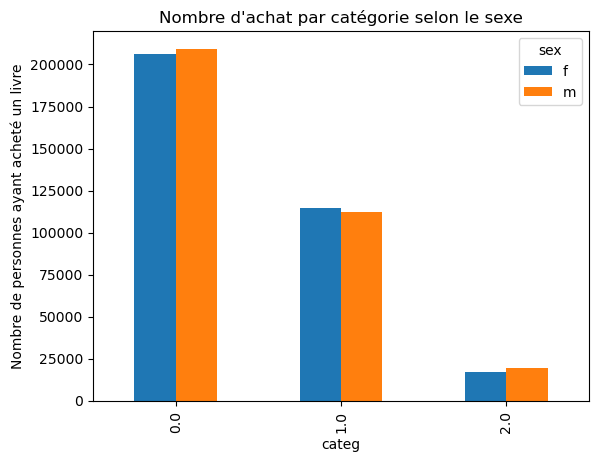

In [99]:
# Pivoter le dataframe pour avoir une colonne par catégorie / Ou kramer
df_pivot = df_grouped.pivot(index='categ', columns='sex', values='id_prod')

# Créer le graphique
df_pivot.plot(kind='bar')

# Configurer les axes et le titre
plt.ylabel('Nombre de personnes ayant acheté un livre')
plt.title("Nombre d'achat par catégorie selon le sexe")

# Afficher le graphique
plt.show()

In [100]:
#Tableau de contingence du nombre de client_id par sexe et par catgéorie acheté
cont = data_f.pivot_table(index='categ',columns='sex',values='client_id',aggfunc=len,margins=True,margins_name="Total")
cont

sex,f,m,Total
categ,,,
0.0,206220,209460,415680
1.0,114899,112270,227169
2.0,17283,19200,36483
Total,338402,340930,679332


In [101]:
print("H0 = Il n'y a pas de corrélation entre le sexe et la catégorie acheté \n",
      "H1 = Il y a corrélation entre le sexe et la catrégorie acheté")

H0 = Il n'y a pas de corrélation entre le sexe et la catégorie acheté 
 H1 = Il y a corrélation entre le sexe et la catrégorie acheté


In [102]:
#Quali x Quali = Chi 2 | Sexe : qualitative / Catégorie : Qualitative
#(quali x quali) +( >2 groupes pour au moins une des deux variables) + (fréquences attendues >5) = test du Chi²

#Test du chi2 d'indépendance des variables dans un tableau de contingence.

In [103]:
test_chi_2(cont,0.05)

Degrès de liberté du tableau de contingence 2
La statistique de Pearson du test khi-deux est :  147.00253568681114 
La p-valeur du test est :  3.327978654785752e-29 

Le quantile de la loi du chi2 à 2 degré de liberté associé au niveau de confiance 0.05 est 5.991464547107979
test Chi-2 : 147.0 > Le quantile de la loi du Chi-2 : 5.99 , on peut donc rejeter H0 avec un risque d'erreur de 0.0 %, il y a donc dépendance


## l’âge des clients et le montant total | Quantitative x Quantitative

In [104]:
#l’âge des clients et le montant total, la fréquence d’achat,la taille du panier moyen et les catégories des livres 

In [105]:
data_f.drop('_merge', axis=1,inplace = True)

In [106]:
data_f['Age'] = 2023 - data_f['birth'] 
data_f.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,Age
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0,f,1986,37
1,0_1627,2022-06-01,s_225494,c_103,3.99,0.0,f,1986,37
2,0_1104,2023-08-01,s_338755,c_103,13.21,0.0,f,1986,37
3,0_1390,2021-04-01,s_23078,c_103,19.37,0.0,f,1986,37
4,0_1547,2022-03-01,s_179629,c_103,8.99,0.0,f,1986,37


In [107]:
#Somme price et garde la première valeur trouvé pour l'âge
session = data_f.groupby('client_id').agg({'price': 'sum', 'Age': 'first'})
session.head()

,price,Age
client_id,,
c_1,558.18,68
c_10,1353.60,67
c_100,254.85,31
c_1000,2261.89,57
c_1001,1812.86,41


In [108]:
bins = [15, 25, 35, 50, 100]
# Appliquer la fonction pd.cut()
session['age_group'] = pd.cut(session['Age'], bins)
session.head()

,price,Age,age_group
client_id,,,
c_1,558.18,68,"(50, 100]"
c_10,1353.60,67,"(50, 100]"
c_100,254.85,31,"(25, 35]"
c_1000,2261.89,57,"(50, 100]"
c_1001,1812.86,41,"(35, 50]"


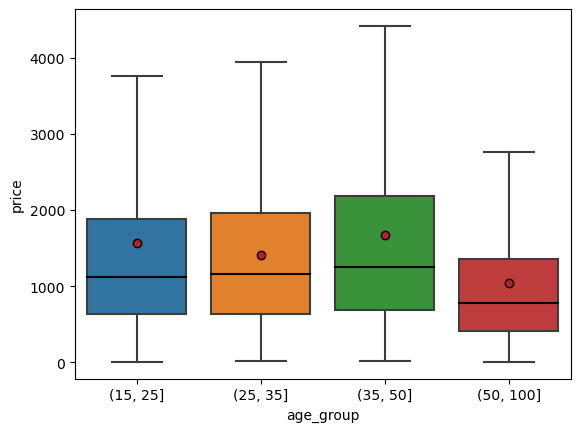

In [109]:
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    

sns.boxplot(x=session['age_group'], y=session['price'], data=data_f,showfliers=False, medianprops=medianprops, 
            showmeans=True, meanprops=meanprops)
   
plt.show()

stat=1.000, p=0.000
La distribution ne semble pas normale (on rejette H0)


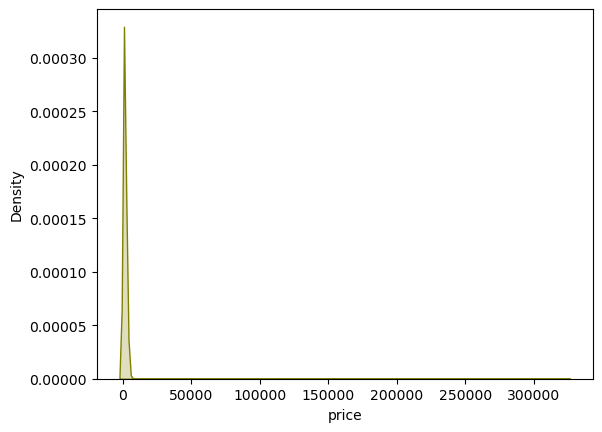

In [110]:
test_normal(session['price'],0.05)

stat=1.000, p=0.000
La distribution ne semble pas normale (on rejette H0)


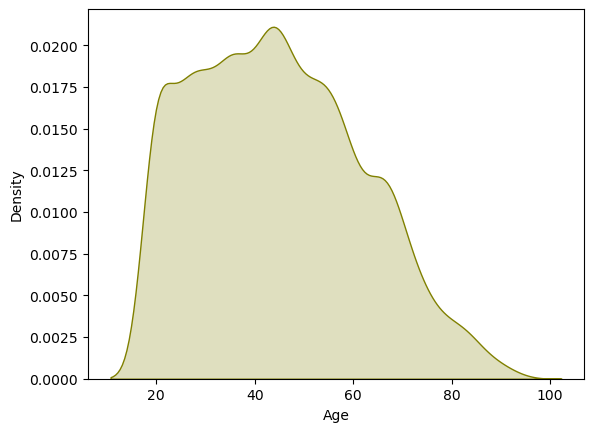

In [111]:
test_normal(session['Age'],0.05)

In [132]:
test_spearmanr(session['Age'],session['price'],0.05) # Att si intervallle == qualitative

Corrélation de rang de Spearman:  -0.18494296074011757
P-value:  4.884465590912483e-67
Il y a une corrélation significative entre les deux variables


## Corrélation âge des clients et fréquence d'achat

In [113]:
#Quanti x Quanti ?

In [114]:
data_f.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,Age
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0,f,1986,37
1,0_1627,2022-06-01,s_225494,c_103,3.99,0.0,f,1986,37
2,0_1104,2023-08-01,s_338755,c_103,13.21,0.0,f,1986,37
3,0_1390,2021-04-01,s_23078,c_103,19.37,0.0,f,1986,37
4,0_1547,2022-03-01,s_179629,c_103,8.99,0.0,f,1986,37


In [115]:
fre_achat = data_f.groupby('client_id').agg({'session_id': 'count', 'Age': 'first'}).reset_index()
fre_achat.head()

,client_id,session_id,Age
0,c_1,39,68
1,c_10,58,67
2,c_100,8,31
3,c_1000,125,57
4,c_1001,102,41


stat=0.993, p=0.000
La distribution ne semble pas normale (on rejette H0)


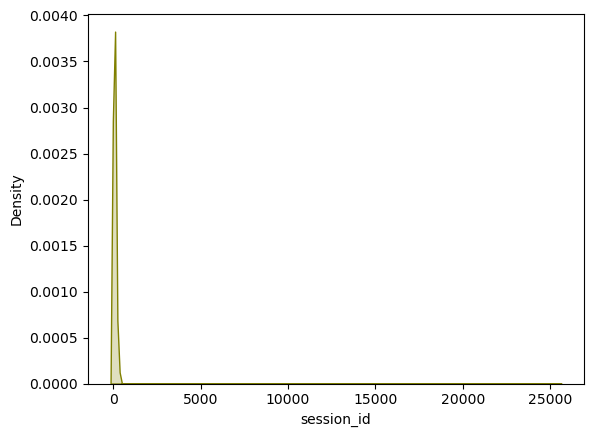

In [116]:
test_normal(fre_achat['session_id'],0.05)

In [117]:
bins = [15, 25, 35, 50, 100]
# Appliquer la fonction pd.cut()
fre_achat['age_group'] = pd.cut(fre_achat['Age'], bins)
fre_achat.head()

,client_id,session_id,Age,age_group
0,c_1,39,68,"(50, 100]"
1,c_10,58,67,"(50, 100]"
2,c_100,8,31,"(25, 35]"
3,c_1000,125,57,"(50, 100]"
4,c_1001,102,41,"(35, 50]"


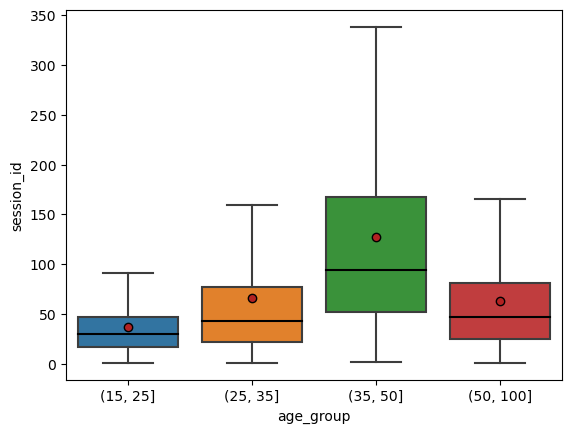

In [118]:
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    

sns.boxplot(x=fre_achat['age_group'], y=fre_achat['session_id'], data=data_f,showfliers=False, medianprops=medianprops, 
            showmeans=True, meanprops=meanprops)
   
plt.show()

In [133]:
test_spearmanr(fre_achat['session_id'],fre_achat['Age'],0.05)

Corrélation de rang de Spearman:  0.12815077877358294
P-value:  8.089296621919091e-33
Il y a une corrélation significative entre les deux variables


## Corrélation âge des clients et taile du manier moyen

In [120]:
#Quanti x Quanti

In [121]:
moy = data_f.groupby('session_id').agg({'price': 'sum', 'Age': 'first'}).reset_index()
moy.head()

,session_id,price,Age
0,s_1,11.99,56
1,s_10,26.99,53
2,s_100,33.72,45
3,s_1000,39.22,34
4,s_10000,41.49,34


In [122]:
bins = [15, 25, 35, 50, 100]
# Appliquer la fonction pd.cut()
moy['age_group'] = pd.cut(moy['Age'], bins)
moy.head()

,session_id,price,Age,age_group
0,s_1,11.99,56,"(50, 100]"
1,s_10,26.99,53,"(50, 100]"
2,s_100,33.72,45,"(35, 50]"
3,s_1000,39.22,34,"(25, 35]"
4,s_10000,41.49,34,"(25, 35]"


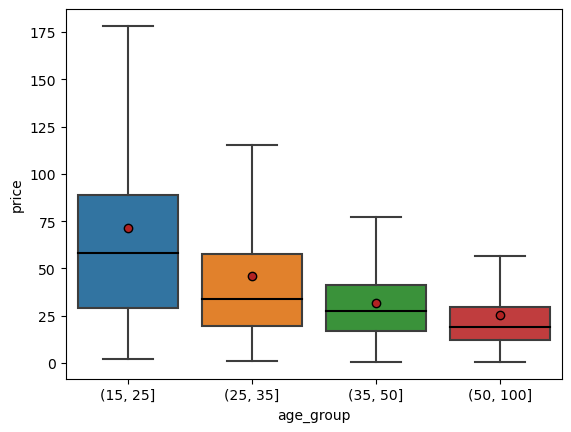

In [123]:
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    

sns.boxplot(x=moy['age_group'], y=moy['price'], data=data_f,showfliers=False, medianprops=medianprops, 
            showmeans=True, meanprops=meanprops)
   
plt.show()

In [142]:
panier_moyen = moy.groupby('Age').mean().reset_index()
#panier_moyen.drop('Age', axis=1,inplace = True)
panier_moyen.head()

,Age,price
0,19,70.864986
1,20,69.417912
2,21,70.740879
3,22,73.425627
4,23,68.165735


stat=1.000, p=0.000
La distribution ne semble pas normale (on rejette H0)


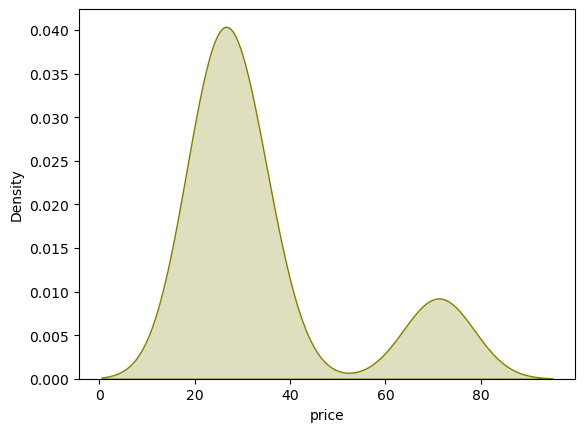

In [143]:
test_normal(panier_moyen['price'],0.05)

In [144]:
test_spearmanr(panier_moyen['Age'],panier_moyen['price'],0.05)

Corrélation de rang de Spearman:  -0.7614217361585783
P-value:  1.4108075296557754e-15
Il y a une corrélation significative entre les deux variables


## Corrélation âge des clients et catégories des livres 

In [127]:
#Quanti x Quali > Non paramétrique

In [128]:
bins = [15, 25, 35, 50, 100]
# Appliquer la fonction pd.cut()
data_f['age_group'] = pd.cut(data_f['Age'], bins)

data_f.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,Age,age_group
0,0_1518,2022-05-01,s_211425,c_103,4.18,0.0,f,1986,37,"(35, 50]"
1,0_1627,2022-06-01,s_225494,c_103,3.99,0.0,f,1986,37,"(35, 50]"
2,0_1104,2023-08-01,s_338755,c_103,13.21,0.0,f,1986,37,"(35, 50]"
3,0_1390,2021-04-01,s_23078,c_103,19.37,0.0,f,1986,37,"(35, 50]"
4,0_1547,2022-03-01,s_179629,c_103,8.99,0.0,f,1986,37,"(35, 50]"


In [129]:
from scipy.stats import kruskal

#Test de test de Kruskal-Wallis, non paramétrique

# Sélectionner la variable quantitative et la variable qualitative
variable_quantitative = data_f['Age']
variable_qualitative = data_f['categ']

# Réaliser le test de Kruskal-Wallis
stat, p = kruskal(variable_quantitative, variable_qualitative)

# Afficher le résultat
# Si la valeur-P est inférieure à un seuil de significativité (par exemple, 0,05), 
#on peut rejeter l'hypothèse nulle et conclure qu'il y a des différences statistiquement significatives 
if p < 0.05:
    print('Les médianes des groupes sont significativement différentes (p-value =', p, ')',
          "il y a donc une relation entre les deux variables")
else:
    print('Les médianes des groupes ne sont pas significativement différentes (p-value =', p, ')',
         "il y a donc aucune relation entre les deux variables")

Les médianes des groupes sont significativement différentes (p-value = 0.0 ) il y a donc une relation entre les deux variables


In [130]:
#peu probable que ces différences soient dues au hasard. En d'autres termes, il y a une association ou 
#une relation entre la variable qualitative et la variable quantitative.

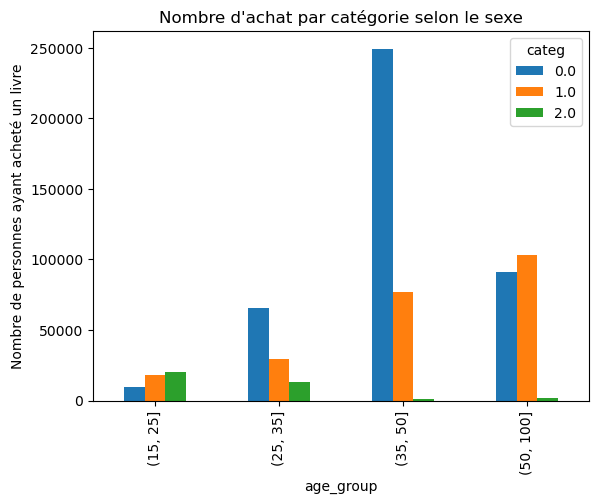

In [131]:
df_grouped = data_f.groupby(['age_group', 'categ'])['id_prod'].count().reset_index()
df_grouped.head()

# Pivoter le dataframe pour avoir une colonne par catégorie
df_pivot = df_grouped.pivot(index='age_group', columns='categ', values='id_prod')

# Créer le graphique
df_pivot.plot(kind='bar')

# Configurer les axes et le titre
plt.ylabel('Nombre de personnes ayant acheté un livre')
plt.title("Nombre d'achat par catégorie selon le sexe")

# Afficher le graphique
plt.show()